In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
import re

from utils.data_processing import *
from time import sleep,time

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, MinMaxScaler

from geopy.geocoders import ArcGIS, Bing, Nominatim, OpenCage, GoogleV3, OpenMapQuest
from geopy.exc import GeocoderTimedOut
from geopy.extra.rate_limiter import RateLimiter

In [2]:
# Original dataset at https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

data_root_path = 'novel-corona-virus-2019-dataset'
data_main_path = os.path.join(data_root_path, 'covid_19_data.csv')

data = pd.read_csv(data_main_path)
data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [3]:
# Utilities, TODO move to utilities folder when done

def do_geocode(address, geocode_obj):
    geocode = RateLimiter(geocode_obj.geocode, min_delay_seconds=1)
    return geocode(address)
    # try:
    #     return geocode.geocode(address)
    # except GeocoderTimedOut:
    #     return do_geocode(address)

# Turn location into latitude and longitude
def numericalize_data(data, geocoders):
    rand_geocoder = random.choice(geocoders)
    if type(data['Province/State']) is not str:
        location = do_geocode(data['Country/Region'], rand_geocoder)
        return (location.latitude, location.longitude)
    location = do_geocode(data['Province/State'], rand_geocoder)
    if location is not None:
        return (location.latitude, location.longitude)
    else:
        return (0, 0)

# handles inconsistency between mm/dd/yyyy vs mm/dd/yy in dataframe and converts all datatime strings into ints
def cen_no_cen_str_to_datetime(date_string):
    try:
        return datetime.datetime.strptime(date_string, '%m/%d/%Y %H:%M')
    except ValueError:
        try:
            return datetime.datetime.strptime(date_string, '%m/%d/%y %H:%M')
        except ValueError:
            try: 
                return datetime.datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S')
            except ValueError:
                return datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')

In [4]:
# See how the disease progresses over time by plotting confirmed, deaths, recovered over time
numericalized_data = data
numericalized_data['ObservationDate'] = numericalized_data['ObservationDate'].apply(lambda x: int(datetime.datetime.strptime(x, '%m/%d/%Y').strftime('%Y%m%d')))


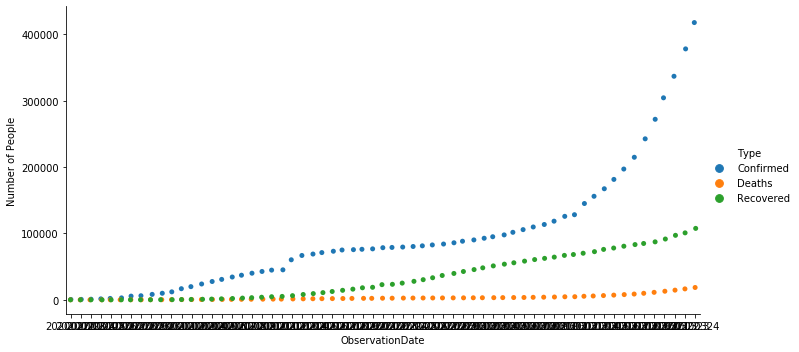

In [5]:
aggregate_data = numericalized_data.groupby('ObservationDate').sum()[['Confirmed', 'Deaths', 'Recovered']].reset_index()
aggregate_data = aggregate_data.melt(id_vars='ObservationDate', value_vars=['Confirmed', 'Deaths', 'Recovered'], var_name='Type', value_name='Number of People')
ctp = sns.catplot(x='ObservationDate', y='Number of People', hue='Type', data=aggregate_data, aspect=2)

In [39]:
# different geocoder service objects to cycle through to avoid rate limits
arcgis = ArcGIS(timeout=100)
bing = Bing('api-key', timeout=100)
nominatim = Nominatim(timeout=100) 
opencage = OpenCage('api-key', timeout=100)
googlev3 = GoogleV3(timeout=100)
openmapquest = OpenMapQuest('api-key', timeout=100)

# At the time of writing this, I used up all my limits on every service except arcgis
geocoders = [arcgis]

# turn Province/State and Country/Region into latitude and longitutde columns
if os.path.exists('fully_numeric_data.csv'):
    fully_numeric_data = pd.read_csv('fully_numeric_data.csv')
else:
    fully_numeric_data = data.apply(numericalize_data, axis=1, args=(geocoders,))

In [40]:
# TODO come up with a better name than temp
temp = data

temp['lat'] = fully_numeric_data['coords'].apply(lambda x: float(x.replace('(', '').split(',')[0]))
temp['long'] = fully_numeric_data['coords'].apply(lambda x: float(x.replace(')', '').split(',')[1]))

# temp.drop(columns=['SNo', 'ObservationDate', 'Last Update', 'Province/State', 'Country/Region'], inplace=True)
temp.drop(columns=['Province/State', 'Country/Region'], inplace=True)

# convert all the date strings to ints
temp['ObservationDate'] = temp['ObservationDate'].apply(lambda x: int(datetime.datetime.strptime(x, '%m/%d/%Y').strftime('%Y%m%d')))
temp['Last Update'] = temp['Last Update'].apply(lambda x: int(cen_no_cen_str_to_datetime(x).strftime('%Y%m%d%H%M')[:8]))

In [41]:
# Scale the features so that they don't dominate cluster decision boundaries
scaler = MinMaxScaler()
temp_arr = scaler.fit_transform(temp)

In [42]:
# Arbitrary number of clusters, TODO perform ELBOW analysis
kmeans = KMeans(n_clusters=5).fit(temp_arr)
labels = kmeans.labels_
temp['labels'] = labels.tolist()

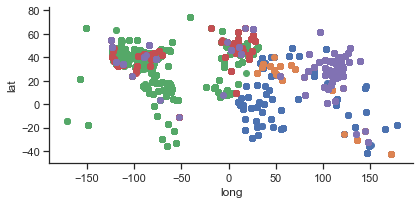

In [68]:
# TODO make sure (0, 0) coordinates are either removed or handled properly, they were the result of failed geocoding ,
sns.set(style='ticks')
fg = sns.FacetGrid(data=temp, hue='labels', hue_order=[0,1,2,3,4], aspect=2)
fg.map(plt.scatter, 'long', 'lat')

In [63]:
reduced_data = PCA(n_components=2).fit_transform(temp_arr)
kmeans = KMeans(init='k-means++', n_clusters=5)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [64]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

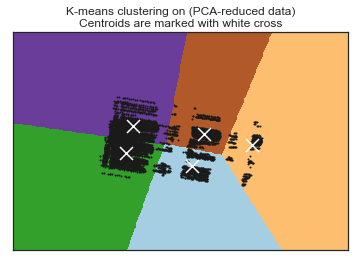

In [65]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
# TODO
# Analyze the individual elements within clusters
# General summary of the data (ie weekly averages, summary statistics)
# Find things to join to data
#   - Amazon data (what did people buy and not buy)
#   - Oil prices?
#   - Social metrics (unemployment, Trump approval rating, Spotify song moods)
# See if trends precede or follow the pandemic in certain areas
# Airline data?
# Website traffic (netflix, etc)
# What did people buy? What didn't they buy?
# Hashtags used, trending in different regions (NLP sentiment analysis)